<a href="https://colab.research.google.com/github/khagerthey/GIS/blob/main/PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

aok: this is good but could have couple more maps

#My Plan
I plan on focusing my research around entrepreneurship. I feel with the useful tool of social media there has been an increase in small businesses. I’m interested in seeing how location within the United States has an effect on the type of businesses, location of buyer vs seller, and correlation between business and local cost of living.

#Resources

https://www.statista.com/statistics/1306812/number-us-etsy-sellers-state/
Here is usable data of the number of sellers in each state! (2021)

https://www.marketplacepulse.com/top-etsy-sellers
Here is usable data of top Etsy sellers! (countries)

US States shapefile link: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

2023 State population table link:
https://worldpopulationreview.com/states

https://www.investopedia.com/unemployment-rate-by-state-4843541
Unemployment rates for 2023 by state.

https://www.statista.com/statistics/409374/etsy-active-sellers/ Here's data on Etsy platform growth from 2012 to 2022.

https://www.statista.com/statistics/208048/median-age-of-population-in-the-usa-by-state/ Data on 2022 average US state ages.

https://www.patriotsoftware.com/blog/accounting/average-cost-living-by-state/ Cost of living data for each state.

https://etsyhunt.com/etsy-product-research Most bought Etsy products.

https://gs.statcounter.com/social-media-stats/all/united-states-of-america Social media usuage data.

https://www.deputy.com/blog/states-with-the-most-women-owned-small-businesses Women and Men data on small businesses

In [1]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter()

import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
!pip install mapclassify
import mapclassify
import numpy as np
import seaborn as sns

import matplotlib.patches as mpatches
from pandas.core.interchange.dataframe_protocol import Column

import plotly.express as px
from wordcloud import WordCloud

#Preparing Data

I am using the 2022 state's population to compare to the 2021 Etsy Seller US population. My hypothesis is that there is a direct correlation between populations. This is a good place to start to try and determine what drives small business success. I'm thinking more people in one location means more potential buyers.

In [2]:
state_population_raw=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/state-population-table.csv')
state_population_columns = state_population_raw[['state', 'pop2022']]
state_population = state_population_columns.rename(columns={'pop2022': 'Total Population in Millions 2022', 'state': 'US State'})
district_of_columbia = pd.DataFrame({'US State': ['District of Columbia'], 'Total Population in Millions 2022': [671803.0]})
puerto_rico = pd.DataFrame({'US State': ['Puerto Rico'], 'Total Population in Millions 2022': [3221789.0]})
combined_states = pd.concat([state_population, district_of_columbia, puerto_rico], ignore_index=True)

combined_states['Total Population in Millions 2022'] = combined_states['Total Population in Millions 2022']/ 1000000
combined_states['Total Population in Millions 2022'] = combined_states['Total Population in Millions 2022'].round(1)

combined_states

,US State,Total Population in Millions 2022
0,California,39.0
1,Texas,30.0
2,Florida,22.2
3,New York,19.7
4,Pennsylvania,13.0
5,Illinois,12.6
6,Ohio,11.8
7,Georgia,10.9
8,North Carolina,10.7
9,Michigan,10.0


In [3]:
etsy_us_sellers=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/etsy_statessellerstats.csv', header=None)
etsy_us_sellers.columns=["US State", "Etsy Sellers in Thousands 2021"]
etsy_sellers = etsy_us_sellers.replace('Washington, D.C.', 'District of Columbia')
etsy_sellers

,US State,Etsy Sellers in Thousands 2021
0,California,465.6
1,Texas,337.3
2,Florida,302.4
3,New York,251.5
4,Pennsylvania,143.3
5,Illinois,133.9
6,Michigan,130.2
7,Ohio,130.1
8,Georgia,128.5
9,North Carolina,123.3


In [4]:
state_seller_comp = pd.merge(combined_states, etsy_sellers, how='outer', on=['US State'], indicator=True)
state_seller_comp
#shows correlation between population and sellers

,US State,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,_merge
0,California,39.0,465.6,both
1,Texas,30.0,337.3,both
2,Florida,22.2,302.4,both
3,New York,19.7,251.5,both
4,Pennsylvania,13.0,143.3,both
5,Illinois,12.6,133.9,both
6,Ohio,11.8,130.1,both
7,Georgia,10.9,128.5,both
8,North Carolina,10.7,123.3,both
9,Michigan,10.0,130.2,both


In [5]:
state_seller_compare = state_seller_comp['Percent of Sellers to Population'] = ((state_seller_comp['Total Population in Millions 2022'] / 100) / state_seller_comp['Etsy Sellers in Thousands 2021'].sum()) *100
state_seller_compare = state_seller_comp.round(3)
state_seller_compare
#Added percentage column so that we can see the actual percent of Etsy sellers. This gives a better evaluation.

,US State,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,_merge,Percent of Sellers to Population
0,California,39.0,465.6,both,0.010
1,Texas,30.0,337.3,both,0.008
2,Florida,22.2,302.4,both,0.006
3,New York,19.7,251.5,both,0.005
4,Pennsylvania,13.0,143.3,both,0.003
5,Illinois,12.6,133.9,both,0.003
6,Ohio,11.8,130.1,both,0.003
7,Georgia,10.9,128.5,both,0.003
8,North Carolina,10.7,123.3,both,0.003
9,Michigan,10.0,130.2,both,0.003


In [6]:
#shapefile of US map states
! wget -q -O cb_2018_us_state_5m.zip https://github.com/khagerthey/GIS/raw/main/cb_2018_us_state_5m.zip


In [7]:
unemployment = pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/data-F0paU.csv', header=None)
unemployment.columns = ["US State", "Unemployment Percentage 2023"]
unemployment = unemployment.iloc[1:]
unemployment_ = unemployment[unemployment['US State'] != 'Puerto Rico']

unemployment_


,US State,Unemployment Percentage 2023
1,Alabama,2.1
2,Alaska,3.9
3,Arizona,3.8
4,Arkansas,2.7
5,California,4.6
6,Colorado,3.1
7,Connecticut,3.6
8,Delaware,4.1
9,District of Columbia,5
10,Florida,2.7


In [8]:
seller_unemployment_ = pd.merge(unemployment_, state_seller_compare, how='outer', on=['US State'], indicator='there')
seller_unemployment = seller_unemployment_.drop(columns='_merge')
seller_unemployment
#okay not to include PR

,US State,Unemployment Percentage 2023,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,Percent of Sellers to Population,there
0,Alabama,2.1,5.1,47.8,0.001,both
1,Alaska,3.9,0.7,8.3,0.000,both
2,Arizona,3.8,7.4,83.4,0.002,both
3,Arkansas,2.7,3.0,28.6,0.001,both
4,California,4.6,39.0,465.6,0.010,both
5,Colorado,3.1,5.8,89.0,0.002,both
6,Connecticut,3.6,3.6,36.7,0.001,both
7,Delaware,4.1,1.0,11.5,0.000,both
8,District of Columbia,5,0.7,7.9,0.000,both
9,Florida,2.7,22.2,302.4,0.006,both


In [9]:
zip_ref = zipfile.ZipFile('cb_2018_us_state_5m.zip', 'r'); zip_ref.extractall(); zip_ref.close() #unzipping
continental_map_data = gpd.read_file('cb_2018_us_state_5m.shp')

map_data = continental_map_data.join(seller_unemployment.set_index("US State"),
                                       on="NAME", rsuffix='_seller')
map_data["Unemployment Percentage 2023"] = map_data["Unemployment Percentage 2023"].astype(float)
#need to change from str to float

In [10]:
cost_ = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/state_avg_income.csv")
cost = cost_.round(1)
cost
#missing entries for avg rent

,US State,Annual Mean Wage (All Occupations),Average Monthly Rent,Value of $100
0,Alabama,"$50,620","$1,055.00",$114.20
1,Alaska,"$66,130","$1,507.00",$94.90
2,Arizona,"$58,620","$1,613.00",$103.70
3,Arkansas,"$48,570",$912.00,$115.30
4,California,"$73,220","$2,032.00",$83.60
5,Colorado,"$67,870","$1,633.00",$98.10
6,Connecticut,"$69,310","$1,533.00",$95.00
7,Delaware,"$62,260","$1,659.00",$100.60
8,Florida,"$55,980","$1,779.00",$99.00
9,Georgia,"$58,000","$1,365.00",$106.80


In [11]:
tot_data_ = pd.merge(cost, seller_unemployment, how='outer', on=['US State'], indicator='present')
total_ = tot_data_.drop(columns='there')
total_

,US State,Annual Mean Wage (All Occupations),Average Monthly Rent,Value of $100,Unemployment Percentage 2023,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,Percent of Sellers to Population,present
0,Alabama,"$50,620","$1,055.00",$114.20,2.1,5.1,47.8,0.001,both
1,Alaska,"$66,130","$1,507.00",$94.90,3.9,0.7,8.3,0.000,both
2,Arizona,"$58,620","$1,613.00",$103.70,3.8,7.4,83.4,0.002,both
3,Arkansas,"$48,570",$912.00,$115.30,2.7,3.0,28.6,0.001,both
4,California,"$73,220","$2,032.00",$83.60,4.6,39.0,465.6,0.010,both
5,Colorado,"$67,870","$1,633.00",$98.10,3.1,5.8,89.0,0.002,both
6,Connecticut,"$69,310","$1,533.00",$95.00,3.6,3.6,36.7,0.001,both
7,Delaware,"$62,260","$1,659.00",$100.60,4.1,1.0,11.5,0.000,both
8,Florida,"$55,980","$1,779.00",$99.00,2.7,22.2,302.4,0.006,both
9,Georgia,"$58,000","$1,365.00",$106.80,3.3,10.9,128.5,0.003,both


In [12]:
age = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/avg_state_age.csv", header = None)
age.columns = ["US State", "Median Age 2022"]
avg_age = age.iloc[3:]
avg_age

,US State,Median Age 2022
3,Maine,45.1
4,New Hampshire,43.3
5,Vermont,43.2
6,West Virginia,42.9
7,Florida,42.7
8,Delaware,41.5
9,Pennsylvania,40.9
10,Connecticut,40.9
11,Hawaii,40.8
12,Rhode Island,40.7


In [13]:
total__ = pd.merge(total_, avg_age, how='outer', on=['US State'], indicator='here')
total_data = total__.drop(columns='present')
total_data

,US State,Annual Mean Wage (All Occupations),Average Monthly Rent,Value of $100,Unemployment Percentage 2023,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,Percent of Sellers to Population,Median Age 2022,here
0,Alabama,"$50,620","$1,055.00",$114.20,2.1,5.1,47.8,0.001,39.6,both
1,Alaska,"$66,130","$1,507.00",$94.90,3.9,0.7,8.3,0.000,35.9,both
2,Arizona,"$58,620","$1,613.00",$103.70,3.8,7.4,83.4,0.002,38.8,both
3,Arkansas,"$48,570",$912.00,$115.30,2.7,3.0,28.6,0.001,38.9,both
4,California,"$73,220","$2,032.00",$83.60,4.6,39.0,465.6,0.010,37.9,both
5,Colorado,"$67,870","$1,633.00",$98.10,3.1,5.8,89.0,0.002,37.7,both
6,Connecticut,"$69,310","$1,533.00",$95.00,3.6,3.6,36.7,0.001,40.9,both
7,Delaware,"$62,260","$1,659.00",$100.60,4.1,1.0,11.5,0.000,41.5,both
8,Florida,"$55,980","$1,779.00",$99.00,2.7,22.2,302.4,0.006,42.7,both
9,Georgia,"$58,000","$1,365.00",$106.80,3.3,10.9,128.5,0.003,37.6,both


#A Look At The Data - General State vs Etsy

In [14]:
us_bounding_box = {
    'lat': [24.396308, 49.384358],
    'lon': [-125.000000, -66.934570]
}

total_data["Unemployment Percentage 2023"] = pd.to_numeric(total_data["Unemployment Percentage 2023"], errors='coerce')
map_data = continental_map_data.join(total_data.set_index("US State"), on="NAME", rsuffix='_seller')

fig = px.choropleth(map_data,
                    geojson=map_data.geometry,
                    locations=map_data.index,
                    color="Percent of Sellers to Population",
                    hover_name="NAME",
                    hover_data=["Total Population in Millions 2022",
                                "Etsy Sellers in Thousands 2021", "Percent of Sellers to Population",
                                "Value of $100", "Median Age 2022"],
                    title="United States General vs Etsy Data",
                    color_continuous_scale="Viridis",
                    )

new_fig = fig.update_layout(
          geo=dict(
              lonaxis_range=[us_bounding_box['lon'][0], us_bounding_box['lon'][1]],
              lataxis_range=[us_bounding_box['lat'][0], us_bounding_box['lat'][1]],
          ),
          title_x=0.42
)

new_fig.show()


This map provides the general population, Etsy population, percentage of Etsy sellers in the general population, unemployment percentage, median age, and value of 100 dollars in each state. There is a loose correlation between the lower value of $100 to unemployment, with the exception of outliers such as Nevada and Texas. There is also a correlation between unemployment and Etsy sellers.

## Unemployment

In [15]:
newmap = map_data.copy()

newmap["geometry"] = newmap["geometry"].centroid

<ipython-input-15-acc6a1c375a5>:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




<Axes: >

<Axes: >

(-127.0, -66.0)

(25.0, 50.0)

[]

[]

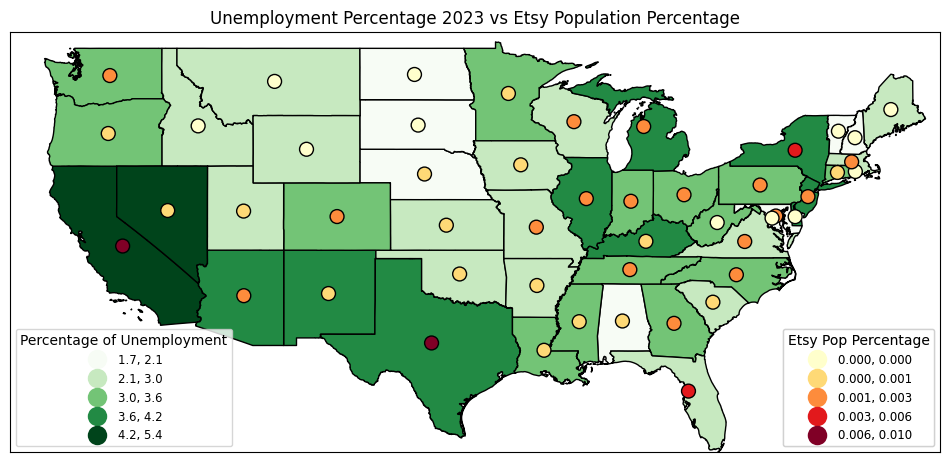

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 25))

map_data.plot(ax=ax, column='Unemployment Percentage 2023', legend=True, cmap='Greens', scheme='natural_breaks', k=5,
              edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.1f}",
                                                           'loc': 'lower left', 'title_fontsize': 'medium',
                                                           'fontsize': 'small', 'markerscale': 1.4})

l1 = ax.get_legend()
l1.set_title('Percentage of Unemployment')

newmap.plot(ax=ax, column='Percent of Sellers to Population', legend=True, cmap='YlOrRd', scheme='natural_breaks', k=5,
             edgecolor='black', linewidth=1, legend_kwds={"fmt": "{:,.3f}",
                                                          'loc': 'lower right', 'title_fontsize': 'medium',
                                                          'fontsize': 'small', 'markerscale': 1.4},
             markersize=100)

ax.set_xlim(-127, -66)
ax.set_ylim(25, 50)
ax.title.set_text("Unemployment Percentage 2023 vs Etsy Population Percentage")
ax.set_xticks([]); ax.set_yticks([])

l2 = ax.get_legend()
l2.set_title('Etsy Pop Percentage')

ax.add_artist(l2)
ax.add_artist(l1)

plt.show()


Comparing unemployment percentage to Etsy seller popultion. According to https://extfiles.etsy.com/Press/reports/Etsy_RedefiningEntrepreneurshipReport_2013.pdf, the seller demographic consists of the median age being 39, 88% female, 52% with a college education, and a median household income of $44,900.

In addition, just 26% of U.S.-based Etsy sellers are full-time employees, while 48% are independent, part time, or temporary workers.

This map shows inconsistent overlaps with Etsy and unemployment. For the most part, we can see a correlation with places like California and Texas. In contrast, we also see a high Etsy population in places like Florida where unemployment is not as high.

## Small Business Demographics

Score.org has reported, "According to the Census Bureau’s Annual Business Survey (ABS), as reported by Forbes, women own more younger businesses than men do. Women own 75% of businesses that are 15 years old or younger, compared to men, who own 66% of them. But men own 34% of small businesses that are 16 years old or older, while women own 25% of them."

Link: https://www.score.org/resource/blog-post/are-women-owned-businesses-successful-male-owned-businesses#:~:text=Women%20own%2075%25%20of%20businesses,women%20own%2025%25%20of%20them.

In [27]:
m_w_business = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/2021us_states_most_women_owned_businesses.csv", skiprows=[0])

m_w_business.columns = ['US State',
'Total No. of Women Owned Businesses',
'Total No. of Women Owned Businesses (Per 100K)',
'Total No. of Men Owned Businesses',
'Total No. of Men Owned Businesses (Per 100K)',
'Gap Between Men & Women Owned Businesses',
'Gap Between Men & Women Owned Businesses (Per 100K)',
'Total No. of Equally Owned Businesses']

m_w_business
#Data based on 2021 Data from The U.S. Small Business Administration Office of Advocacy

,US State,Total No. of Women Owned Businesses,Total No. of Women Owned Businesses (Per 100K),Total No. of Men Owned Businesses,Total No. of Men Owned Businesses (Per 100K),Gap Between Men & Women Owned Businesses,Gap Between Men & Women Owned Businesses (Per 100K),Total No. of Equally Owned Businesses
0,Arizona,"224,252.00","3,082.00","315,902.00","4,342.00","91,650.00","1,260.00","36,985.00"
1,Arkansas,"91,168.00","3,013.00","139,877.00","4,623.00","48,709.00","1,610.00","14,681.00"
2,California,"1,541,927.00","3,930.00","\t\n2,279,714.00","5,810.00","737,787.00","1,880.00","179,196.00"
3,Colorado,"244,479.00","4,206.00","353,111.00","6,075.00","108,632.00","1,869.00","38,460.00"
4,Connecticut,"122,409.00","3,395.00","199,797.00","5,541.00","77,388.00","2,146.00","14,443.00"
5,Delaware,"27,499.00","2,741.00","45,355.00","4,520.00","17,856.00","1,780.00","5,214.00"
6,District of Columbia,"31,849.00","4,753.00","38,103.00","5,687.00","6,254.00",933,"2,026.00"
7,Florida,"1,034,013.00","4,747.00","1,422,301.00","6,530.00","388,288.00","1,783.00","128,307.00"
8,Georgia,"452,913.00","4,194.00","577,447.00","5,347.00","124,534.00","1,153.00","35,551.00"
9,Hawaii,"54,361.00","3,771.00","69,953.00","4,853.00","15,592.00","1,082.00","5,645.00"


In [28]:
# Merging the DataFrames
women_men = pd.merge(m_w_business, total_data, how='outer', on=['US State'], indicator='there')

# Dropping the unnecessary column
business_states = women_men.drop(columns='here')
business_states


,US State,Total No. of Women Owned Businesses,Total No. of Women Owned Businesses (Per 100K),Total No. of Men Owned Businesses,Total No. of Men Owned Businesses (Per 100K),Gap Between Men & Women Owned Businesses,Gap Between Men & Women Owned Businesses (Per 100K),Total No. of Equally Owned Businesses,Annual Mean Wage (All Occupations),Average Monthly Rent,Value of $100,Unemployment Percentage 2023,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,Percent of Sellers to Population,Median Age 2022,there
0,Arizona,"224,252.00","3,082.00","315,902.00","4,342.00","91,650.00","1,260.00","36,985.00","$58,620","$1,613.00",$103.70,3.8,7.4,83.4,0.002,38.8,both
1,Arkansas,"91,168.00","3,013.00","139,877.00","4,623.00","48,709.00","1,610.00","14,681.00","$48,570",$912.00,$115.30,2.7,3.0,28.6,0.001,38.9,both
2,California,"1,541,927.00","3,930.00","\t\n2,279,714.00","5,810.00","737,787.00","1,880.00","179,196.00","$73,220","$2,032.00",$83.60,4.6,39.0,465.6,0.010,37.9,both
3,Colorado,"244,479.00","4,206.00","353,111.00","6,075.00","108,632.00","1,869.00","38,460.00","$67,870","$1,633.00",$98.10,3.1,5.8,89.0,0.002,37.7,both
4,Connecticut,"122,409.00","3,395.00","199,797.00","5,541.00","77,388.00","2,146.00","14,443.00","$69,310","$1,533.00",$95.00,3.6,3.6,36.7,0.001,40.9,both
5,Delaware,"27,499.00","2,741.00","45,355.00","4,520.00","17,856.00","1,780.00","5,214.00","$62,260","$1,659.00",$100.60,4.1,1.0,11.5,0.000,41.5,both
6,District of Columbia,"31,849.00","4,753.00","38,103.00","5,687.00","6,254.00",933,"2,026.00",NaN,NaN,NaN,5.0,0.7,7.9,0.000,34.9,both
7,Florida,"1,034,013.00","4,747.00","1,422,301.00","6,530.00","388,288.00","1,783.00","128,307.00","$55,980","$1,779.00",$99.00,2.7,22.2,302.4,0.006,42.7,both
8,Georgia,"452,913.00","4,194.00","577,447.00","5,347.00","124,534.00","1,153.00","35,551.00","$58,000","$1,365.00",$106.80,3.3,10.9,128.5,0.003,37.6,both
9,Hawaii,"54,361.00","3,771.00","69,953.00","4,853.00","15,592.00","1,082.00","5,645.00","$61,420","$2,312.00",$80.70,2.8,1.4,15.2,0.000,40.8,both


In [ ]:
# m_w_business["Total No. of Women Owned Businesses (Per 100K)"] = pd.to_numeric(m_w_business["Total No. of Women Owned Businesses (Per 100K)"], errors='coerce')
# plot_map = continental_map_data.join(m_w_business.set_index("US State"), on="NAME", rsuffix='_seller')

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the map data
#continental_map_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load and preprocess the business data
#m_w_business = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/2021us_states_most_women_owned_businesses.csv")
business_states["Total No. of Women Owned Businesses (Per 100K)"] = pd.to_numeric(business_states["Total No. of Women Owned Businesses (Per 100K)"].str.replace(',', ''), errors='coerce')
business_states["Total No. of Men Owned Businesses (Per 100K)"] = pd.to_numeric(business_states["Total No. of Men Owned Businesses (Per 100K)"].str.replace(',', ''), errors='coerce')

# Rename the "State" column to "name" to match the map data
business_states = business_states.rename(columns={"State": "name"})

# Set the state name as the index for both dataframes
continental_map_data = continental_map_data.set_index("name")
business_states = business_states.set_index("name")

# Join the business data with the map data
plot_map = continental_map_data.join(m_w_business)

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Set xlim and ylim for the continental US
ax1.set_xlim(-127, -66)
ax1.set_ylim(25, 50)

# Women-owned Businesses Map
plot_map.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
plot_map.plot(ax=ax1, column='Total No. of Women Owned Businesses (Per 100K)', legend=True, cmap='YlOrRd', scheme='quantiles', k=3,
              legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium',
                           'fontsize': 'small', 'markerscale': 1.4, 'title': 'Total No. of Women Owned Businesses (Per 100K)'})

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top', 'left']:
    ax1.spines[edge].set_visible(False)

ax1.set_title('Total No. of Women Owned Businesses (Per 100K)', size=12, weight='bold')

# Set xlim and ylim for the continental US
ax2.set_xlim(-127, -66)
ax2.set_ylim(25, 50)

# Men-owned Businesses Map
plot_map.boundary.plot(ax=ax2, edgecolor='black', linewidth=0.5)
plot_map.plot(ax=ax2, column='Total No. of Men Owned Businesses (Per 100K)', legend=True, cmap='Blues', scheme='quantiles', k=3,
              legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium',
                           'fontsize': 'small', 'markerscale': 1.4, 'title': 'Total No. of Men Owned Businesses (Per 100K)'})

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top', 'left']:
    ax2.spines[edge].set_visible(False)

ax2.set_title('Total No. of Men Owned Businesses (Per 100K)', size=12, weight='bold')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the map data
continental_map_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load and preprocess the business data
m_w_business = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/2021us_states_most_women_owned_businesses.csv")
m_w_business["Total No. of Women Owned Businesses (Per 100K)"] = pd.to_numeric(m_w_business["Total No. of Women Owned Businesses (Per 100K)"].str.replace(',', ''), errors='coerce')
m_w_business["Total No. of Men Owned Businesses (Per 100K)"] = pd.to_numeric(m_w_business["Total No. of Men Owned Businesses (Per 100K)"].str.replace(',', ''), errors='coerce')

# Rename the "State" column to "name" to match the map data
m_w_business = m_w_business.rename(columns={"State": "name"})

# Join the business data with the map data
plot_map = continental_map_data.join(m_w_business.set_index("name"), on="name", rsuffix='_seller')

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Set xlim and ylim for the continental US
ax1.set_xlim(-127, -66)
ax1.set_ylim(25, 50)

# Women-owned Businesses Map
plot_map.boundary.plot(ax=ax1, edgecolor='black', linewidth=0.5)
plot_map.plot(ax=ax1, column='Total No. of Women Owned Businesses (Per 100K)', legend=True, cmap='YlOrRd', scheme='natural_breaks', k=5,
              legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium',
                           'fontsize': 'small', 'markerscale': 1.4, 'title': 'Total No. of Women Owned Businesses (Per 100K)'})

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top', 'left']:
    ax1.spines[edge].set_visible(False)

ax1.set_title('Total No. of Women Owned Businesses (Per 100K)', size=12, weight='bold')

# Set xlim and ylim for the continental US
ax2.set_xlim(-127, -66)
ax2.set_ylim(25, 50)

# Men-owned Businesses Map
plot_map.boundary.plot(ax=ax2, edgecolor='black', linewidth=0.5)
plot_map.plot(ax=ax2, column='Total No. of Men Owned Businesses (Per 100K)', legend=True, cmap='Blues', scheme='natural_breaks', k=5,
              legend_kwds={"fmt": "{:,.0f}", 'loc': 'lower right', 'title_fontsize': 'medium',
                           'fontsize': 'small', 'markerscale': 1.4, 'title': 'Total No. of Men Owned Businesses (Per 100K)'})

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top', 'left']:
    ax2.spines[edge].set_visible(False)

ax2.set_title('Total No. of Men Owned Businesses (Per 100K)', size=12, weight='bold')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



##Etsy Age

Here's some key Etsy Stats provided by https://extfiles.etsy.com/Press/reports/Etsy_NewFaceofCreativeEntrepreneurship_2015.pdf.


aok: interesting!

In [19]:
data = {
    'Metric': ['Median age (years)', 'Gender (% female)', 'Education (% college grad or more)',
               'Median household income', 'Rural (%)'],
    'Etsy Sellers': [39, 86, 56, 56180, 39],
    'General Population': [37.5, 51, 27, 52250, 21]
}

df = pd.DataFrame(data)
df.set_index('Metric', inplace=True)
print(df)

median_age_diff = df.loc['Median age (years)', 'Etsy Sellers'] - df.loc['Median age (years)', 'General Population']
print(f"Median Age Difference: {median_age_diff} years")

gender_diff = df.loc['Gender (% female)', 'Etsy Sellers'] - df.loc['Gender (% female)', 'General Population']
print(f"Gender Difference: {gender_diff}%")

edu_diff = df.loc['Education (% college grad or more)', 'Etsy Sellers'] - df.loc['Education (% college grad or more)', 'General Population']
print(f"Education Difference: {edu_diff}%")

income_diff = df.loc['Median household income', 'Etsy Sellers'] - df.loc['Median household income', 'General Population']
print(f"Median Household Income Difference: ${income_diff}")

rural_diff = df.loc['Rural (%)', 'Etsy Sellers'] - df.loc['Rural (%)', 'General Population']
print(f"Rural Population Difference: {rural_diff}%")


                                    Etsy Sellers  General Population
Metric                                                              
Median age (years)                            39                37.5
Gender (% female)                             86                51.0
Education (% college grad or more)            56                27.0
Median household income                    56180             52250.0
Rural (%)                                     39                21.0
Median Age Difference: 1.5 years
Gender Difference: 35.0%
Education Difference: 29.0%
Median Household Income Difference: $3930.0
Rural Population Difference: 18.0%


The average Etsy seller age in the United States is 39 with a large population of females. Based on the United States General vs Etsy Data map above, California, having the highest Etsy population also has an average age of 38, only a year younger than the Etsy average. Although, states like Florida with an older average of 43 and Texas with a younger average of 36 (the second and third highest Etsy populated states) show that there may not be an exterme link between the gerneral average age and Etsy's average age.

#Top Products

In [20]:
product_detail = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/product_detail.csv")
#product_detail

<Figure size 1500x500 with 0 Axes>

<Axes: >

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for Product')

<Axes: >

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Word Cloud for Category')

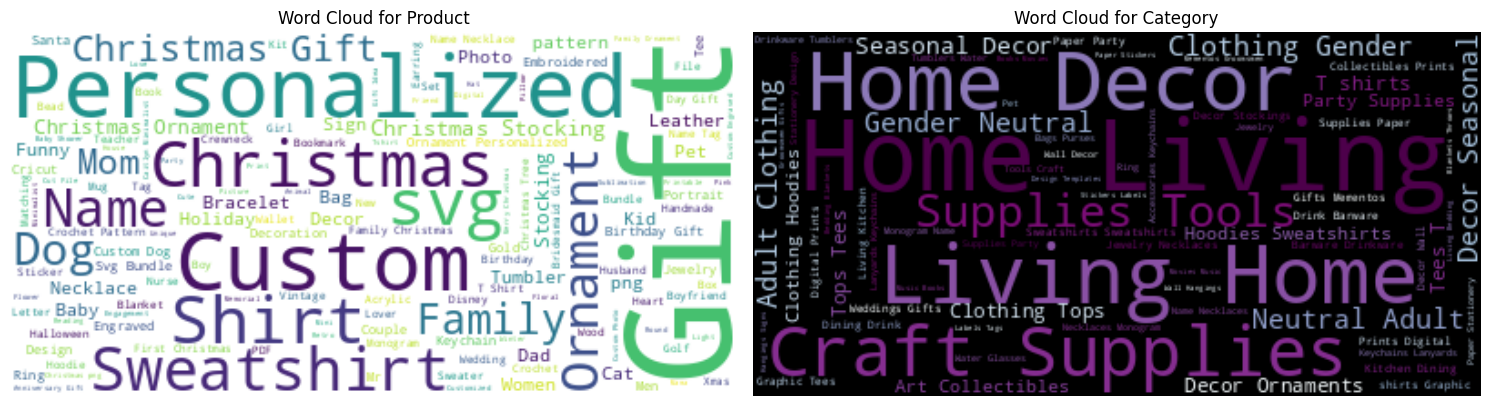

In [21]:
all_products_title = ' '.join(product_detail['Title'].astype(str))
wordcloud_title = WordCloud(width=400, height=200, background_color='white').generate(all_products_title)

all_products_category = ' '.join(product_detail['Category'].astype(str))
wordcloud_category = WordCloud(width=400, height=200, background_color='black', colormap='BuPu_r').generate(all_products_category)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Product')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_category, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Category')

plt.tight_layout()

plt.show()


This word cloud provides a fun visual way to see what are the most common product and description words. As we can see, on the left the most common product descriptions use personalized, gift, custom, and Christmas. Etsy shops are known to be great for personalized gifts.


The most common product categories for sellers to cater to is home decor, home living, and craft supplies. Using this data, one could infer that making personalized home decor would be a competitive market, but also likely lucrative with people willing to buy.

#Marketing

According to Neal Schaffer, businesses that invest in social media marketing will produce an average of $2.80 on the dollar return on investment. In addition, bussiness that are interactive on social media are more likely to see an increase in website traffic and brand awareness.

Resource: https://nealschaffer.com/social-media-roi/#:~:text=social%20media%20advertising.-,Does%20social%20media%20marketing%20actually%20generate%20ROI%3F,%242.80%20for%20every%20dollar%20spent.

In [22]:
social = pd.read_csv("https://raw.githubusercontent.com/khagerthey/GIS/main/social_media-US-monthly-202210-202310.csv")
social

,Date,Facebook,Twitter,Instagram,Pinterest,YouTube,reddit,LinkedIn,Tumblr,Fark,news.ycombinator.com,StumbleUpon,Sina Weibo,VKontakte,Other
0,2022-10,56.86,12.84,10.86,15.34,2.17,1.11,0.38,0.30,0.07,0.05,0.01,0.01,0.01,0.00
1,2022-11,51.83,13.25,13.49,16.25,2.14,1.94,0.45,0.45,0.09,0.10,0.01,0.01,0.01,0.00
2,2022-12,49.93,14.87,14.84,15.85,2.13,1.55,0.37,0.31,0.09,0.04,0.01,0.01,0.01,0.00
3,2023-01,52.67,18.87,11.64,12.67,2.02,1.06,0.68,0.29,0.04,0.03,0.01,0.03,0.01,0.00
4,2023-02,55.10,16.48,12.26,12.34,1.94,0.92,0.49,0.29,0.06,0.05,0.02,0.02,0.01,0.00
5,2023-03,53.09,16.25,13.85,12.77,2.08,0.91,0.60,0.28,0.06,0.04,0.03,0.03,0.01,0.00
6,2023-04,51.95,19.47,13.38,11.46,1.86,0.96,0.49,0.27,0.07,0.04,0.02,0.02,0.01,0.00
7,2023-05,50.87,19.74,14.72,10.75,1.99,0.95,0.49,0.35,0.07,0.02,0.01,0.01,0.02,0.00
8,2023-06,48.25,21.83,15.91,10.01,2.12,0.92,0.53,0.29,0.07,0.03,0.01,0.01,0.02,0.01
9,2023-07,52.09,14.49,15.78,13.45,1.91,1.38,0.53,0.27,0.05,0.00,0.00,0.01,0.02,0.02


<Figure size 800x800 with 0 Axes>

Text(0.5, 1.0, 'U.S. Social Media Usage')

([<matplotlib.patches.Wedge at 0x7c924d994070>,
 [Text(1.1957638669683461, -0.10074112592634406, 'Facebook'),
  Text(-0.6998195665893493, -0.8486769551594385, 'Twitter'),
  Text(-1.0956883585206778, 0.09729861767909534, 'Instagram'),
  Text(-0.6060175471548895, 0.9180102028520007, 'Pinterest'),
  Text(-0.07312776907733116, 1.0975665489571795, 'YouTube')],
 [Text(0.697528922398202, -0.05876565679036737, '52.7%'),
  Text(-0.38171976359419046, -0.46291470281423913, '16.6%'),
  Text(-0.5976481955567333, 0.053071973279506544, '14.3%'),
  Text(-0.33055502572084877, 0.5007328379192731, '14.3%'),
  Text(-0.03988787404218063, 0.5986726630675524, '2.1%')])

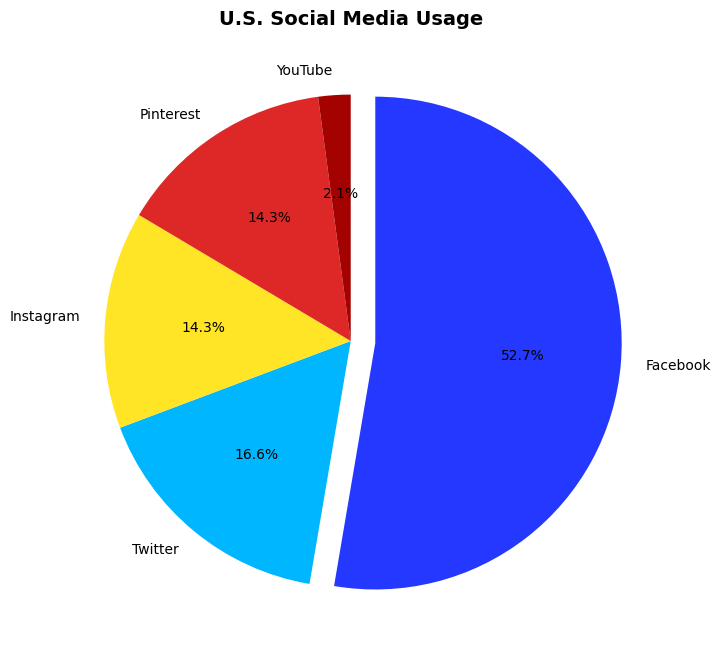

In [23]:
total_social = social[['Facebook', 'Twitter', 'Instagram', 'Pinterest', 'YouTube']].sum()

plt.figure(figsize=(8, 8))
plt.title('U.S. Social Media Usage', size=14, weight='bold')

colors = ['#2538FF', '#00B6FF', '#FFE525', '#DE2828', '#A40101']
exp = [0.1, 0, 0, 0, 0]

plt.pie(x=total_social, autopct='%.1f%%', explode=exp, labels=total_social.index, colors=colors, startangle=90, counterclock=False)
plt.show()


Facebook by far has the greatest outreach, with over 50% of usage in the United States, October 2022 to October 2023. It's clear that Facebook is a great platform to utilize for marketing due to its large outreach.